루브릭


1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.	

> 데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.

2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.	

> U-Net generator, discriminator 모델 구현이 완료되어 train_step의 output을 확인하고 개선하였다.

3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.	

> 10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.

데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해 주세요.
(어떠한 방법을 사용했는지 적어주세요.)

이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해 주세요.

모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운로드했던 "val" 폴더 내 이미지를 사용해 주세요.

1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.

모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.


In [5]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

In [7]:
import sys
dataset_name = 'cityscapes'
path = os.path.abspath('./')
_URL = f'file://'+path+'/data/cityscapes.zip'

path_to_zip = tf.keras.utils.get_file(
    fname=f"{dataset_name}.zip",
    origin=_URL,
    extract=True)

path_to_zip  = pathlib.Path(path_to_zip)

PATH = path_to_zip.parent/dataset_name

30195712/30179339 [==============================] - 0s 0us/step


In [8]:
list(PATH.parent.iterdir())

[PosixPath('/aiffel/.keras/datasets/cityscapes.zip'),
 PosixPath('/aiffel/.keras/datasets/cityscapes')]

데이터 확인

In [9]:
sample_image = tf.io.read_file(str(PATH / 'train/1.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

(256, 512, 3)


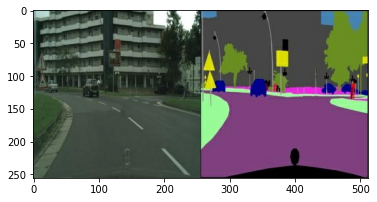

In [10]:
plt.figure()
plt.imshow(sample_image)

In [11]:
def load(image_file):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)

    # Split each image tensor into two tensors:
    # - one with a real building facade image
    # - one with an architecture label image 
    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, w:, :]
    real_image = image[:, :w, :]

    # Convert both images to float32 tensors
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image


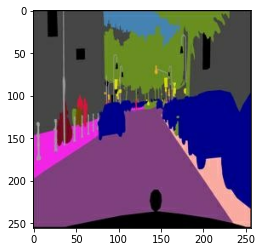

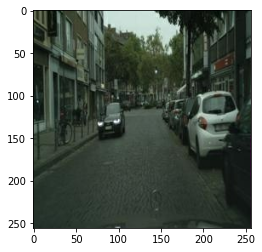

In [12]:
inp, re = load(str(PATH / 'train/100.jpg'))
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

이미지 전처리 함수

In [13]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [14]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image


In [15]:
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

In [16]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

In [17]:
@tf.function()
def random_jitter(input_image, real_image):
    # Resizing to 286x286
    input_image, real_image = resize(input_image, real_image, 286, 286)
    
    # Random cropping back to 256x256
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

In [18]:
# 랜덤 flip 함수
def do_random_flip(input_image, real_image):
    if tf.random.uniform(())>0.5:
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)
    if tf.random.uniform(())>0.5:
        input_image = tf.image.flip_up_down(input_image)
        real_image = tf.image.flip_up_down(real_image)
    if tf.random.uniform(())>0.5:
        input_image = tf.image.transpose(input_image)
        real_image = tf.image.transpose(real_image)
    return input_image, real_image

추가 생성

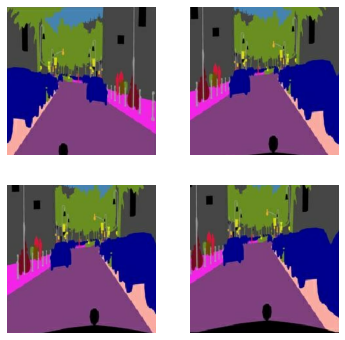

In [19]:
plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)
    plt.subplot(2, 2, i + 1)
    plt.imshow(rj_inp / 255.0)
    plt.axis('off')
plt.show()


앞선 전처리 함수를 통해 이미지 로드

In [20]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    input_image, real_image = do_random_flip(input_image, real_image)
    return input_image, real_image


In [21]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

tf.data 데이터 입력 파이프라인 구축

In [22]:
train_dataset = tf.data.Dataset.list_files(str(PATH / 'train/*.jpg'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [23]:
try:
    test_dataset = tf.data.Dataset.list_files(str(PATH / 'test/*.jpg'))
except tf.errors.InvalidArgumentError:
    test_dataset = tf.data.Dataset.list_files(str(PATH / 'val/*.jpg'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

생성기 구축 - 

In [24]:
from tensorflow.keras import layers, Input, Model

class GeneratorGAN(Model):
    def __init__(self):
        super(GeneratorGAN, self).__init__()

        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(256, activation='relu')
        self.dense_3 = layers.Dense(512, activation='relu')
        self.dense_4 = layers.Dense(28*28*1, activation='tanh')

        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise):
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out)


In [25]:
class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        self.dense_z = layers.Dense(256, activation='relu')
        self.dense_y = layers.Dense(256, activation='relu')
        self.combined_dense = layers.Dense(512, activation='relu')
        self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise, label):
        noise = self.dense_z(noise)
        label = self.dense_y(label)
        out = self.combined_dense(tf.concat([noise, label], axis=-1))
        out = self.final_dense(out)
        return self.reshape(out)
    

In [26]:
class DiscriminatorGAN(Model):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.blocks = []
        for f in [512, 256, 128, 1]:
            self.blocks.append(
                layers.Dense(f, activation=None if f==1 else "relu")
            )
        
    def call(self, x):
        x = self.flatten(x)
        for block in self.blocks:
            x = block(x)
        return x
    

In [27]:
class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        self.dense = layers.Dense(units*pieces, activation="relu")
        self.dropout = layers.Dropout(.5)    
        self.reshape = layers.Reshape((-1, pieces, units))
    
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=2)


In [28]:
class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.image_block = Maxout(240, 5)
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        
        self.dense = layers.Dense(1, activation=None)
    
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image)
        label = self.label_block(label)
        x = layers.Concatenate()([image, label])
        x = self.combine_block(x)
        return self.dense(x)
    

In [43]:
import numpy as np
gan_generator = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()

@tf.function()
def gan_step(real_images):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        # Generator를 이용해 가짜 이미지 생성
        fake_images = gan_generator(noise)
        # Discriminator를 이용해 진짜 및 가짜이미지를 각각 판별
        real_out = gan_discriminator(real_images)
        fake_out = gan_discriminator(fake_images)
        # 각 손실(loss)을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    # gradient 계산
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
    return gene_loss, disc_loss

In [30]:
EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    for i, images in enumerate(train_dataset):
        gene_loss, disc_loss = gan_step(images)

        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}")

AttributeError: in user code:

    /tmp/ipykernel_31/801245110.py:6 gan_step  *
        noise = tf.random.normal([real_images.shape[0], 100])

    AttributeError: 'tuple' object has no attribute 'shape'


In [48]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)


In [49]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()


In [50]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

In [53]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [54]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [55]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

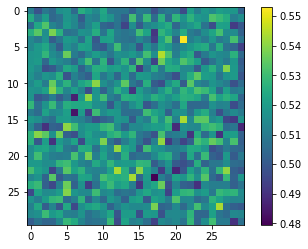

In [56]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

get_disc_loss: 진짜 이미지 및 1의 배열(실제 이미지이기 때문에)의 시그모이드 교차 엔트로피 손실과 생성된 이미지 및 0의 배열(가짜 이미지이기 때문에)의 시그모이드 교차 엔트로피 손실의 합계

In [61]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)


In [62]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [63]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss


In [65]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_dataset):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.8744                     
L1_loss:0.3226                     
Discriminator_loss:1.5237

EPOCH[1] - STEP[20]                     
Generator_loss:1.0372                     
L1_loss:0.2486                     
Discriminator_loss:1.2269

EPOCH[1] - STEP[30]                     
Generator_loss:1.0869                     
L1_loss:0.1930                     
Discriminator_loss:1.1574

EPOCH[1] - STEP[40]                     
Generator_loss:1.1906                     
L1_loss:0.2154                     
Discriminator_loss:1.1367

EPOCH[1] - STEP[50]                     
Generator_loss:1.3972                     
L1_loss:0.1240                     
Discriminator_loss:1.2757

EPOCH[1] - STEP[60]                     
Generator_loss:0.6467                     
L1_loss:0.1761                     
Discriminator_loss:1.4478

EPOCH[1] - STEP[70]                     
Generator_loss:0.6206                     
L1_loss:0.2624                    

EPOCH[1] - STEP[570]                     
Generator_loss:1.2306                     
L1_loss:0.2303                     
Discriminator_loss:0.4267

EPOCH[1] - STEP[580]                     
Generator_loss:1.9511                     
L1_loss:0.2058                     
Discriminator_loss:0.2661

EPOCH[1] - STEP[590]                     
Generator_loss:0.5453                     
L1_loss:0.1805                     
Discriminator_loss:2.1710

EPOCH[1] - STEP[600]                     
Generator_loss:1.1281                     
L1_loss:0.1916                     
Discriminator_loss:0.4762

EPOCH[1] - STEP[610]                     
Generator_loss:2.9508                     
L1_loss:0.1304                     
Discriminator_loss:0.9750

EPOCH[1] - STEP[620]                     
Generator_loss:1.1163                     
L1_loss:0.1717                     
Discriminator_loss:0.6591

EPOCH[1] - STEP[630]                     
Generator_loss:2.0127                     
L1_loss:0.1733             

EPOCH[2] - STEP[130]                     
Generator_loss:0.4554                     
L1_loss:0.1476                     
Discriminator_loss:1.2396

EPOCH[2] - STEP[140]                     
Generator_loss:0.8055                     
L1_loss:0.1716                     
Discriminator_loss:0.8810

EPOCH[2] - STEP[150]                     
Generator_loss:1.1883                     
L1_loss:0.1351                     
Discriminator_loss:0.5307

EPOCH[2] - STEP[160]                     
Generator_loss:1.5456                     
L1_loss:0.2501                     
Discriminator_loss:1.5218

EPOCH[2] - STEP[170]                     
Generator_loss:2.2081                     
L1_loss:0.1213                     
Discriminator_loss:1.0382

EPOCH[2] - STEP[180]                     
Generator_loss:0.9949                     
L1_loss:0.1442                     
Discriminator_loss:1.5281

EPOCH[2] - STEP[190]                     
Generator_loss:0.5040                     
L1_loss:0.1372             

EPOCH[2] - STEP[690]                     
Generator_loss:1.1860                     
L1_loss:0.1607                     
Discriminator_loss:0.6122

EPOCH[2] - STEP[700]                     
Generator_loss:1.4412                     
L1_loss:0.2177                     
Discriminator_loss:0.4422

EPOCH[2] - STEP[710]                     
Generator_loss:1.6184                     
L1_loss:0.2809                     
Discriminator_loss:0.2543

EPOCH[2] - STEP[720]                     
Generator_loss:1.7933                     
L1_loss:0.1524                     
Discriminator_loss:0.9214

EPOCH[2] - STEP[730]                     
Generator_loss:1.3927                     
L1_loss:0.1829                     
Discriminator_loss:0.3588

EPOCH[2] - STEP[740]                     
Generator_loss:1.9057                     
L1_loss:0.1796                     
Discriminator_loss:0.7442

EPOCH[2] - STEP[750]                     
Generator_loss:1.8967                     
L1_loss:0.1590             

EPOCH[3] - STEP[250]                     
Generator_loss:1.7691                     
L1_loss:0.1650                     
Discriminator_loss:0.6709

EPOCH[3] - STEP[260]                     
Generator_loss:1.0934                     
L1_loss:0.1985                     
Discriminator_loss:0.4907

EPOCH[3] - STEP[270]                     
Generator_loss:1.7921                     
L1_loss:0.1217                     
Discriminator_loss:1.3628

EPOCH[3] - STEP[280]                     
Generator_loss:1.3107                     
L1_loss:0.2435                     
Discriminator_loss:0.3688

EPOCH[3] - STEP[290]                     
Generator_loss:1.6715                     
L1_loss:0.1825                     
Discriminator_loss:0.3829

EPOCH[3] - STEP[300]                     
Generator_loss:1.8495                     
L1_loss:0.1793                     
Discriminator_loss:2.5513

EPOCH[3] - STEP[310]                     
Generator_loss:1.7776                     
L1_loss:0.1833             

EPOCH[3] - STEP[810]                     
Generator_loss:2.5135                     
L1_loss:0.2480                     
Discriminator_loss:0.1065

EPOCH[3] - STEP[820]                     
Generator_loss:1.5382                     
L1_loss:0.2464                     
Discriminator_loss:0.4174

EPOCH[3] - STEP[830]                     
Generator_loss:0.7469                     
L1_loss:0.1597                     
Discriminator_loss:0.8205

EPOCH[3] - STEP[840]                     
Generator_loss:2.2267                     
L1_loss:0.1419                     
Discriminator_loss:2.1542

EPOCH[3] - STEP[850]                     
Generator_loss:2.2995                     
L1_loss:0.1390                     
Discriminator_loss:1.1028

EPOCH[3] - STEP[860]                     
Generator_loss:1.5286                     
L1_loss:0.2328                     
Discriminator_loss:0.2974

EPOCH[3] - STEP[870]                     
Generator_loss:1.3530                     
L1_loss:0.1963             

EPOCH[4] - STEP[370]                     
Generator_loss:2.1964                     
L1_loss:0.1371                     
Discriminator_loss:1.2129

EPOCH[4] - STEP[380]                     
Generator_loss:2.0438                     
L1_loss:0.1231                     
Discriminator_loss:0.6478

EPOCH[4] - STEP[390]                     
Generator_loss:1.6201                     
L1_loss:0.1448                     
Discriminator_loss:0.7345

EPOCH[4] - STEP[400]                     
Generator_loss:1.5383                     
L1_loss:0.2053                     
Discriminator_loss:0.5269

EPOCH[4] - STEP[410]                     
Generator_loss:1.0435                     
L1_loss:0.2330                     
Discriminator_loss:0.4869

EPOCH[4] - STEP[420]                     
Generator_loss:1.4961                     
L1_loss:0.1603                     
Discriminator_loss:0.4715

EPOCH[4] - STEP[430]                     
Generator_loss:2.6000                     
L1_loss:0.1849             

EPOCH[4] - STEP[930]                     
Generator_loss:0.5473                     
L1_loss:0.2034                     
Discriminator_loss:1.0477

EPOCH[4] - STEP[940]                     
Generator_loss:1.1864                     
L1_loss:0.1765                     
Discriminator_loss:0.4657

EPOCH[4] - STEP[950]                     
Generator_loss:1.1569                     
L1_loss:0.1572                     
Discriminator_loss:1.5335

EPOCH[4] - STEP[960]                     
Generator_loss:2.5042                     
L1_loss:0.1513                     
Discriminator_loss:1.2174

EPOCH[4] - STEP[970]                     
Generator_loss:1.7671                     
L1_loss:0.1207                     
Discriminator_loss:1.0885

EPOCH[4] - STEP[980]                     
Generator_loss:1.3353                     
L1_loss:0.1732                     
Discriminator_loss:0.5336

EPOCH[4] - STEP[990]                     
Generator_loss:2.0284                     
L1_loss:0.2366             

EPOCH[5] - STEP[490]                     
Generator_loss:1.4737                     
L1_loss:0.2032                     
Discriminator_loss:0.6593

EPOCH[5] - STEP[500]                     
Generator_loss:1.1646                     
L1_loss:0.1472                     
Discriminator_loss:0.5273

EPOCH[5] - STEP[510]                     
Generator_loss:0.6505                     
L1_loss:0.1996                     
Discriminator_loss:1.1389

EPOCH[5] - STEP[520]                     
Generator_loss:0.5064                     
L1_loss:0.1552                     
Discriminator_loss:1.4404

EPOCH[5] - STEP[530]                     
Generator_loss:2.6259                     
L1_loss:0.1986                     
Discriminator_loss:0.6000

EPOCH[5] - STEP[540]                     
Generator_loss:2.0793                     
L1_loss:0.1741                     
Discriminator_loss:0.2607

EPOCH[5] - STEP[550]                     
Generator_loss:3.2923                     
L1_loss:0.2180             

EPOCH[6] - STEP[50]                     
Generator_loss:0.8589                     
L1_loss:0.1737                     
Discriminator_loss:0.9751

EPOCH[6] - STEP[60]                     
Generator_loss:2.2916                     
L1_loss:0.2008                     
Discriminator_loss:2.9619

EPOCH[6] - STEP[70]                     
Generator_loss:2.7908                     
L1_loss:0.1427                     
Discriminator_loss:0.7770

EPOCH[6] - STEP[80]                     
Generator_loss:1.9133                     
L1_loss:0.2278                     
Discriminator_loss:0.3330

EPOCH[6] - STEP[90]                     
Generator_loss:0.9949                     
L1_loss:0.1439                     
Discriminator_loss:1.0464

EPOCH[6] - STEP[100]                     
Generator_loss:1.2393                     
L1_loss:0.1587                     
Discriminator_loss:0.8172

EPOCH[6] - STEP[110]                     
Generator_loss:1.1032                     
L1_loss:0.2401                  

EPOCH[6] - STEP[610]                     
Generator_loss:2.6919                     
L1_loss:0.2930                     
Discriminator_loss:0.0906

EPOCH[6] - STEP[620]                     
Generator_loss:1.0399                     
L1_loss:0.1688                     
Discriminator_loss:0.5738

EPOCH[6] - STEP[630]                     
Generator_loss:3.2496                     
L1_loss:0.1835                     
Discriminator_loss:1.7022

EPOCH[6] - STEP[640]                     
Generator_loss:2.4899                     
L1_loss:0.2021                     
Discriminator_loss:0.1344

EPOCH[6] - STEP[650]                     
Generator_loss:1.2582                     
L1_loss:0.1475                     
Discriminator_loss:0.6669

EPOCH[6] - STEP[660]                     
Generator_loss:1.0578                     
L1_loss:0.2143                     
Discriminator_loss:0.5079

EPOCH[6] - STEP[670]                     
Generator_loss:1.8417                     
L1_loss:0.2119             

EPOCH[7] - STEP[170]                     
Generator_loss:1.6147                     
L1_loss:0.1433                     
Discriminator_loss:1.6279

EPOCH[7] - STEP[180]                     
Generator_loss:0.2038                     
L1_loss:0.2127                     
Discriminator_loss:1.9021

EPOCH[7] - STEP[190]                     
Generator_loss:0.8392                     
L1_loss:0.1770                     
Discriminator_loss:0.7014

EPOCH[7] - STEP[200]                     
Generator_loss:1.4062                     
L1_loss:0.1547                     
Discriminator_loss:1.0527

EPOCH[7] - STEP[210]                     
Generator_loss:0.2213                     
L1_loss:0.1515                     
Discriminator_loss:1.9254

EPOCH[7] - STEP[220]                     
Generator_loss:1.2176                     
L1_loss:0.1993                     
Discriminator_loss:0.5247

EPOCH[7] - STEP[230]                     
Generator_loss:1.6462                     
L1_loss:0.2432             

EPOCH[7] - STEP[730]                     
Generator_loss:1.4904                     
L1_loss:0.1539                     
Discriminator_loss:0.6626

EPOCH[7] - STEP[740]                     
Generator_loss:0.7217                     
L1_loss:0.1735                     
Discriminator_loss:1.3424

EPOCH[7] - STEP[750]                     
Generator_loss:1.9492                     
L1_loss:0.1675                     
Discriminator_loss:0.2083

EPOCH[7] - STEP[760]                     
Generator_loss:1.7030                     
L1_loss:0.1603                     
Discriminator_loss:0.7102

EPOCH[7] - STEP[770]                     
Generator_loss:3.6386                     
L1_loss:0.1444                     
Discriminator_loss:0.9079

EPOCH[7] - STEP[780]                     
Generator_loss:1.3480                     
L1_loss:0.2197                     
Discriminator_loss:0.3494

EPOCH[7] - STEP[790]                     
Generator_loss:2.1126                     
L1_loss:0.1472             

EPOCH[8] - STEP[290]                     
Generator_loss:1.8895                     
L1_loss:0.1606                     
Discriminator_loss:0.3763

EPOCH[8] - STEP[300]                     
Generator_loss:2.4702                     
L1_loss:0.2550                     
Discriminator_loss:0.1028

EPOCH[8] - STEP[310]                     
Generator_loss:1.7939                     
L1_loss:0.1692                     
Discriminator_loss:0.4291

EPOCH[8] - STEP[320]                     
Generator_loss:2.3097                     
L1_loss:0.1468                     
Discriminator_loss:1.2160

EPOCH[8] - STEP[330]                     
Generator_loss:1.7679                     
L1_loss:0.2469                     
Discriminator_loss:0.2332

EPOCH[8] - STEP[340]                     
Generator_loss:2.3270                     
L1_loss:0.2754                     
Discriminator_loss:0.1258

EPOCH[8] - STEP[350]                     
Generator_loss:0.4909                     
L1_loss:0.1391             

EPOCH[8] - STEP[850]                     
Generator_loss:1.5745                     
L1_loss:0.1853                     
Discriminator_loss:0.3146

EPOCH[8] - STEP[860]                     
Generator_loss:1.4629                     
L1_loss:0.1616                     
Discriminator_loss:0.4166

EPOCH[8] - STEP[870]                     
Generator_loss:1.5642                     
L1_loss:0.1927                     
Discriminator_loss:0.2950

EPOCH[8] - STEP[880]                     
Generator_loss:1.4997                     
L1_loss:0.1552                     
Discriminator_loss:0.3487

EPOCH[8] - STEP[890]                     
Generator_loss:1.5135                     
L1_loss:0.1256                     
Discriminator_loss:1.3998

EPOCH[8] - STEP[900]                     
Generator_loss:1.1763                     
L1_loss:0.1370                     
Discriminator_loss:0.5892

EPOCH[8] - STEP[910]                     
Generator_loss:0.9660                     
L1_loss:0.1886             

EPOCH[9] - STEP[410]                     
Generator_loss:2.9923                     
L1_loss:0.1563                     
Discriminator_loss:2.1078

EPOCH[9] - STEP[420]                     
Generator_loss:1.8699                     
L1_loss:0.2557                     
Discriminator_loss:0.2460

EPOCH[9] - STEP[430]                     
Generator_loss:2.9522                     
L1_loss:0.2224                     
Discriminator_loss:0.0799

EPOCH[9] - STEP[440]                     
Generator_loss:1.5038                     
L1_loss:0.1678                     
Discriminator_loss:0.3972

EPOCH[9] - STEP[450]                     
Generator_loss:1.6233                     
L1_loss:0.1781                     
Discriminator_loss:0.3108

EPOCH[9] - STEP[460]                     
Generator_loss:1.6975                     
L1_loss:0.1495                     
Discriminator_loss:0.7985

EPOCH[9] - STEP[470]                     
Generator_loss:2.7284                     
L1_loss:0.1663             

EPOCH[9] - STEP[970]                     
Generator_loss:1.9608                     
L1_loss:0.1877                     
Discriminator_loss:0.5819

EPOCH[9] - STEP[980]                     
Generator_loss:1.3773                     
L1_loss:0.1697                     
Discriminator_loss:1.1874

EPOCH[9] - STEP[990]                     
Generator_loss:2.0186                     
L1_loss:0.2196                     
Discriminator_loss:0.1601

EPOCH[9] - STEP[1000]                     
Generator_loss:0.9119                     
L1_loss:0.2180                     
Discriminator_loss:0.6086

EPOCH[10] - STEP[10]                     
Generator_loss:0.1695                     
L1_loss:0.2482                     
Discriminator_loss:2.8504

EPOCH[10] - STEP[20]                     
Generator_loss:1.0610                     
L1_loss:0.1750                     
Discriminator_loss:0.5297

EPOCH[10] - STEP[30]                     
Generator_loss:1.2100                     
L1_loss:0.1577            

EPOCH[10] - STEP[530]                     
Generator_loss:2.2267                     
L1_loss:0.1688                     
Discriminator_loss:1.0146

EPOCH[10] - STEP[540]                     
Generator_loss:0.5443                     
L1_loss:0.1094                     
Discriminator_loss:1.5139

EPOCH[10] - STEP[550]                     
Generator_loss:2.2842                     
L1_loss:0.1406                     
Discriminator_loss:0.7006

EPOCH[10] - STEP[560]                     
Generator_loss:3.1785                     
L1_loss:0.1476                     
Discriminator_loss:2.0617

EPOCH[10] - STEP[570]                     
Generator_loss:1.7041                     
L1_loss:0.1596                     
Discriminator_loss:0.6769

EPOCH[10] - STEP[580]                     
Generator_loss:2.4984                     
L1_loss:0.1816                     
Discriminator_loss:0.1534

EPOCH[10] - STEP[590]                     
Generator_loss:2.4963                     
L1_loss:0.1371      

In [73]:
test_dataset

<BatchDataset shapes: ((None, 256, 256, None), (None, 256, 256, None)), types: (tf.float32, tf.float32)>

In [75]:
test_ind = 100

#f = PATH + os.listdir(PATH)[test_ind]
#sketch, colored = load_img(test_dataset)

sketch, colored = next(iter(test_dataset.take(1)))
pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

ValueError: Input 0 of layer batch_normalization_58 is incompatible with the layer: expected ndim=4, found ndim=5. Full shape received: (1, 1, 64, 64, 128)